【小白向】髋关节，三类标签，图像分割

Reference/forked from：https://github.com/talhaanwarch/course

Data from: https://data.mendeley.com/datasets/zm6bxzhmfz

In [1]:
%%capture
!pip install nibabel
!pip install pytorch-lightning
!pip install torchmetrics
!pip install -U albumentations
!pip install segmentation-models-pytorch
!pip install -U opencv-python-headless==4.1.2.30

In [3]:
pip list 

Package                     Version
--------------------------- ------------
absl-py                     1.3.0
aiohttp                     3.8.3
aiosignal                   1.3.1
albumentations              1.3.0
anyio                       3.6.2
argon2-cffi                 21.3.0
argon2-cffi-bindings        21.2.0
arrow                       1.2.3
asttokens                   2.2.1
async-timeout               4.0.2
attrs                       22.1.0
backcall                    0.2.0
beautifulsoup4              4.11.1
bleach                      5.0.1
cachetools                  5.2.0
celluloid                   0.2.0
certifi                     2022.9.24
cffi                        1.15.1
charset-normalizer          2.1.1
click                       8.1.3
colorama                    0.4.6
comm                        0.1.2
commonmark                  0.9.1
contourpy                   1.0.6
cycler                      0.11.0
debugpy                     1.6.4
decorator                   5

# 下载数据集

In [5]:
import os
if os.path.isfile('data.zip') is False:
  !wget --no-check-certificate https://data.mendeley.com/api/datasets-v2/datasets/zm6bxzhmfz/zip/download?version=1 -O data.zip

In [6]:
%%capture
from zipfile import ZipFile
if os.path.isdir('data') is False:
  with ZipFile('zm6bxzhmfz-1.zip') as zf:
    zf.extractall('data')

# 读取数据

In [7]:
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Python glob()函数的作用和用法
https://blog.csdn.net/xjp_xujiping/article/details/81604882

glob是python自己带的一个文件操作相关模块，用它可以查找符合自己目的的文件，类似于Windows下的文件搜索

glob模块的主要方法就是glob,该方法返回所有匹配的文件路径列表（list）

其返回的文件名只包括当前目录里的文件名，不包括子文件夹里的文件

### Python sorted() 函数
https://www.runoob.com/python/python-func-sorted.html

sorted() 函数对所有可迭代的对象进行排序操作。

### Python zip()用法，看这一篇就够了
https://blog.csdn.net/PaulZhn/article/details/104391756

### Python zip() 函数
https://www.runoob.com/python/python-func-zip.html

### 一文看懂如何用 Python 查看三维数据 (nii.gz格式) 的各种图像参数
https://blog.csdn.net/u014264373/article/details/119545255

In [8]:
images=sorted(glob('./data/images/*.nii.gz'))
labels=sorted(glob('./data/labels/*.nii.gz'))
data_dicts=[{
    "image":image_name,'label':label_name}                # 字典，"key": value
    for image_name,label_name in zip(images,labels)
    ]

In [9]:
train_files,val_files=train_test_split(data_dicts,test_size=0.2,random_state=0)

In [10]:
train_files[0]

{'image': './data/images\\image_019.nii.gz',
 'label': './data/labels\\label_019.nii.gz'}

### numpy.squeeze()函数
https://blog.csdn.net/zenghaitao0128/article/details/78512715

(512, 324, 1) (512, 324, 1)
2.0 0.0


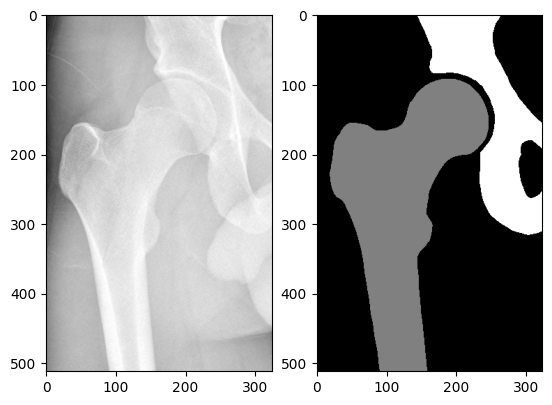

In [11]:
import nibabel as nib
image=nib.load(train_files[0]['image']).get_fdata() # 转成np图片
mask=nib.load(train_files[0]['label']).get_fdata()
print(image.shape,mask.shape)
print(mask.max(),mask.min())
fig,ax=plt.subplots(1,2)
ax[0].imshow(np.squeeze(image,-1),cmap='gray') # 最后一个维度
ax[1].imshow(np.squeeze(mask,-1),cmap='gray')

### np.squeeze what means axis=-1?
https://stackoverflow.com/questions/59238020/np-squeeze-what-means-axis-1

### Numpy——“axis=-1”的含义（表示最后一个轴）
https://blog.csdn.net/songyuc/article/details/104953241

### 【numpy】argmax参数辨析（axis=0,axis=1,axis=-1)
https://blog.csdn.net/weixin_39190382/article/details/105854567?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-1-105854567-blog-104953241.pc_relevant_vip_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-1-105854567-blog-104953241.pc_relevant_vip_default&utm_relevant_index=2

### 【python】详解numpy库与pandas库axis=0，axis= 1轴的用法
https://blog.csdn.net/brucewong0516/article/details/79030994

标签有三类：pelvis骨盆 femur股骨 background

# 数据增强

In [12]:
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader,Dataset
import torch

In [13]:
train_aug=A.Compose(
    [
     A.Resize(512,512),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.Rotate(10),
     A.GaussNoise(p=0.1),
     A.Normalize(mean=(0),std=(1)),
     ToTensorV2(p=1.0)
    ]
)


val_aug=A.Compose(
    [
     A.Resize(512,512),
     A.Normalize(mean=(0),std=(1)),
     ToTensorV2(p=1.0)
    ]
)

In [17]:
class DataReader(Dataset):
  def __init__(self,data,transform):
    self.data=data
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_path=self.data[index]['image']
    label_path=self.data[index]['label']

    image=nib.load(image_path).get_fdata()
    label=nib.load(label_path).get_fdata()

    transformed=self.transform(image=image,mask=label)
    image=transformed['image']
    label=transformed['mask']
    label=torch.moveaxis(label,2,0)  ######## 需要注意  ########

    return image,label

### 注意一点  检查label的shape

In [18]:
sample_data=DataReader(data=data_dicts,transform=train_aug)
sample_loader=DataLoader(sample_data,batch_size=4)
sample_batch=next(iter(sample_loader))

In [19]:
sample_batch[0].shape,sample_batch[1].shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

### PyTorch中permute的用法
https://blog.csdn.net/york1996/article/details/81876886

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'batch of masks')

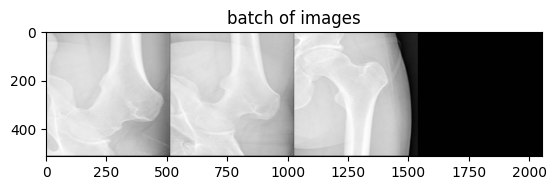

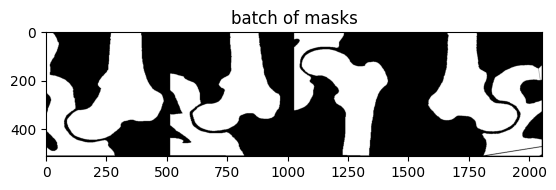

In [20]:
plt.figure()
grid_image=torchvision.utils.make_grid(sample_batch[0],4,1)
plt.imshow(grid_image.permute(1,2,0))  # “置换” 将tensor的维度换位
plt.title('batch of images')
plt.figure()
grid_image=torchvision.utils.make_grid(sample_batch[1],4,1)
plt.imshow(grid_image.permute(1,2,0))
plt.title('batch of masks')

# 模型

### Segmentation Model
https://github.com/qubvel/segmentation_models.pytorch

In [21]:
import segmentation_models_pytorch as smp
from pytorch_lightning import seed_everything,LightningModule,Trainer
import torchmetrics
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from segmentation_models_pytorch.losses import DiceLoss

### 机器学习——损失函数(loss)与评价指标(metric)的区别？
https://zhuanlan.zhihu.com/p/373032887

###  Keras API reference 学习一些概念
https://keras.io/api/

### Dice Loss

语义分割之dice loss深度分析（梯度可视化）
https://zhuanlan.zhihu.com/p/269592183

dice loss 是应用于语义分割而不是分类任务，并且是一个区域相关的loss

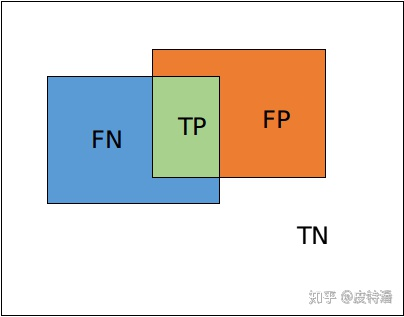

医学影像分割---Dice Loss
https://zhuanlan.zhihu.com/p/86704421

F-score 和 Dice Loss
https://zhuanlan.zhihu.com/p/394114653

### IoU 评价函数

检测评价函数IoU的理解与实现
https://www.jianshu.com/p/a4237e252087
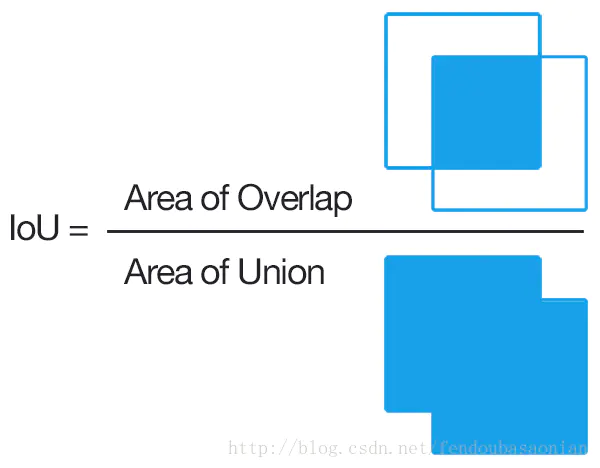

目标检测中IOU评价函数
https://blog.csdn.net/qq_45359288/article/details/108376742

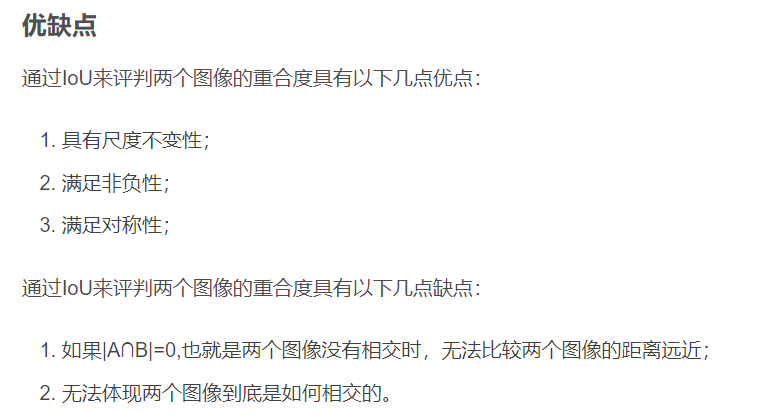

In [24]:
class SegmentClass(LightningModule):
  def __init__(self):
    super(SegmentClass,self).__init__()

    #model
    self.model = smp.Unet(
        encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,                      # model output channels (number of classes in your dataset)
    )
    #loss function
    self.loss=DiceLoss(mode='multiclass',classes=3,from_logits=True)
    #metric
    #self.iou=torchmetrics.IoU(3)
    self.iou=torchmetrics.JaccardIndex(task="multiclass", num_classes=3)
    #batchsize
    self.batchsize=24
    #lr
    self.lr=1e-3

  def forward(self,x) :
    return self.model(x)
      
  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(),lr=self.lr,weight_decay=1e-5)
    scheduler=CosineAnnealingWarmRestarts(opt,T_0=10,T_mult=1,eta_min=1e-5,last_epoch=-1)
    return {'optimizer':opt,'lr_scheduler':scheduler}

  def train_dataloader(self):
    data=DataReader(data=train_files,transform=train_aug)
    loader=DataLoader(data,batch_size=self.batchsize,shuffle=True)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch[0],torch.squeeze(batch[1],1).long()    #################
    out=self(image)
    loss=self.loss(out,segment)
    iou=self.iou(out,segment)
    self.log('train_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
    self.log('train_iou',iou,on_step=False,on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    data=DataReader(data=val_files,transform=val_aug)
    loader=DataLoader(data,batch_size=self.batchsize,shuffle=False)
    return loader

  def validation_step(self,batch,batch_idx):
    image,segment=batch[0],torch.squeeze(batch[1],1).long()
    out=self(image)
    loss=self.loss(out,segment)
    iou=self.iou(out,segment)
    self.log('val_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
    self.log('val_iou',iou,on_step=False,on_epoch=True,prog_bar=True)
    return loss

In [25]:
model=SegmentClass()

# 训练

In [26]:
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor=LearningRateMonitor(logging_interval='epoch')

trainer=Trainer(max_epochs=50,gpus=1,precision=16,callbacks=[lr_monitor])

C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model)

Missing logger folder: H:\0. videos\Bilibili\医学AI-图像分割] 髋关节分割-Pytorch源码\try2\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | Unet                   | 24.4 M
1 | loss  | DiceLoss               | 0     
2 | iou   | MulticlassJaccardIndex | 0     
-------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
48.861    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\pytorch_lightning\trainer\trainer.py:1595: PossibleUserWarning: The number of training batches (5) is smaller than

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


# 测试

In [28]:
model=model.to('cuda')
test_loader=model.val_dataloader()
model.eval()
with torch.no_grad():
  imgs,preds,labels=[],[],[]
  for img,seg in test_loader:
    pred=model(img.to('cuda'))
    pred=torch.sigmoid(pred)
    imgs.append(img)
    preds.append(pred)
    labels.append(seg)

### 【pytorch系列】model.eval()用法详解
https://blog.csdn.net/sazass/article/details/116616664
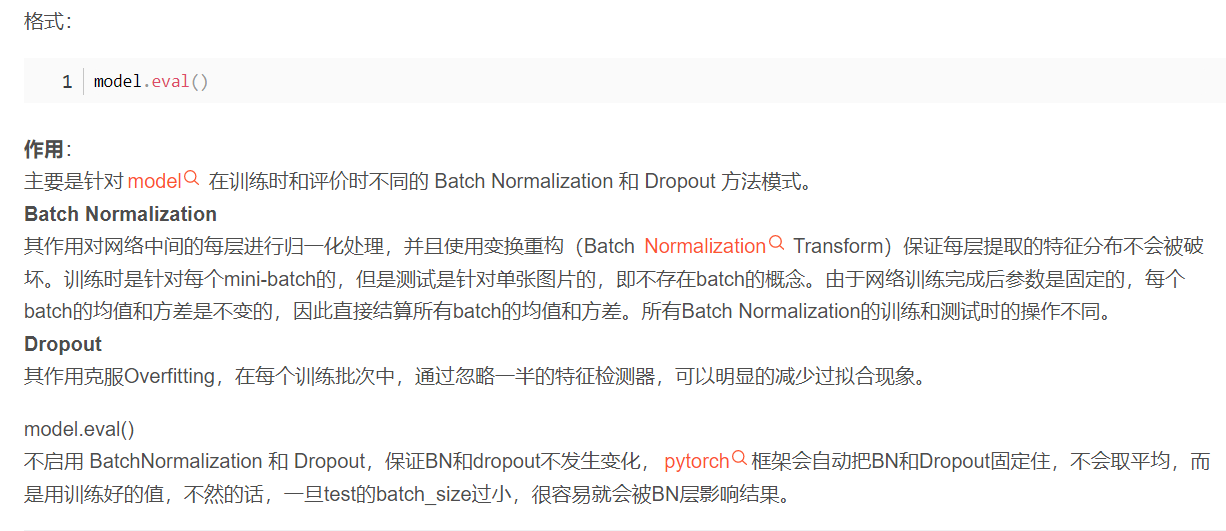

### TORCH.CAT
https://pytorch.org/docs/stable/generated/torch.cat.html

In [29]:
imgs_array=torch.cat(imgs)
preds_array=torch.cat(preds)
labels_array=torch.cat(labels)
imgs_array.shape,preds_array.shape,labels_array.shape

(torch.Size([28, 1, 512, 512]),
 torch.Size([28, 3, 512, 512]),
 torch.Size([28, 1, 512, 512]))

In [30]:
imgs_array=torch.squeeze(imgs_array,dim=1)
labels_array=torch.squeeze(labels_array,dim=1)
preds_array=torch.argmax(preds_array,dim=1)
imgs_array.shape,preds_array.shape,labels_array.shape

(torch.Size([28, 512, 512]),
 torch.Size([28, 512, 512]),
 torch.Size([28, 512, 512]))

In [31]:
imgs_array=imgs_array.detach().numpy()
labels_array=labels_array.detach().numpy()
preds_array=preds_array.detach().cpu().numpy()

### Why do we call .detach() before calling .numpy() on a Pytorch Tensor?
https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor
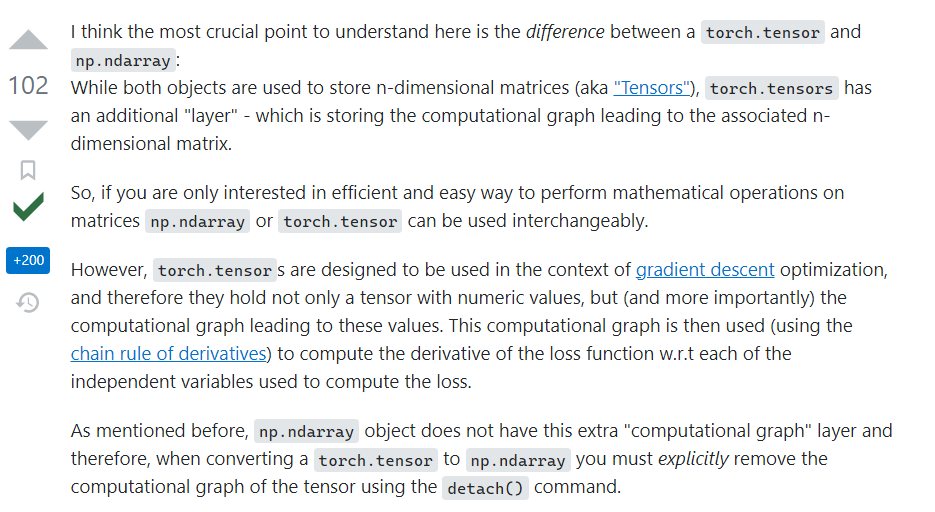

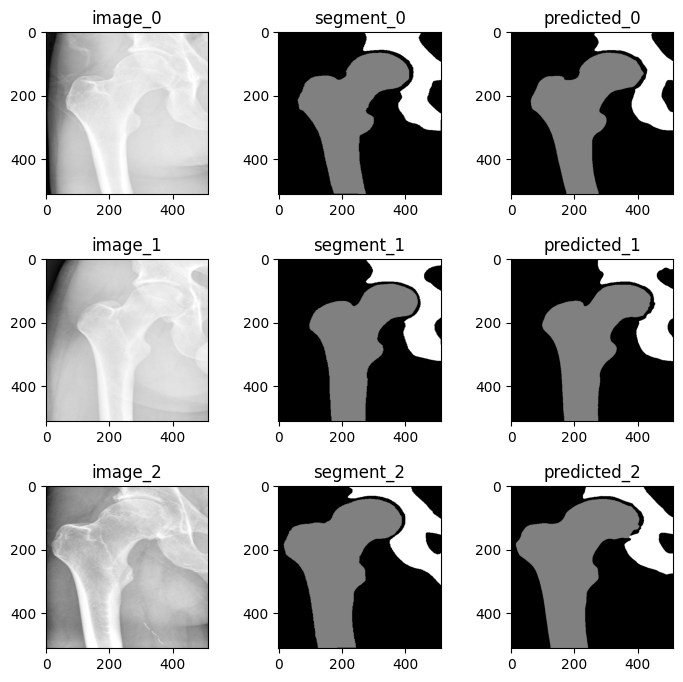

In [32]:
fig,ax=plt.subplots(3,3,figsize=(16,8))
for i in range(3):
  ax[i,0].imshow(imgs_array[i,:,:],cmap='gray')
  ax[i,0].set_title('image_{}'.format(i))
  ax[i,1].imshow(labels_array[i,:,:],cmap='gray')
  ax[i,1].set_title('segment_{}'.format(i))
  ax[i,2].imshow(preds_array[i,:,:],cmap='gray')
  ax[i,2].set_title('predicted_{}'.format(i))
plt.subplots_adjust(wspace=-0.7, hspace=0.4)